In [285]:
import pandas as pd
import numpy as np
import cvxpy
from oracles import Oracle
from FISTA import FISTA
from ADMM import ADMM
from APG import AcceleratedProximalGD
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [286]:
data = pd.read_csv('stocks_data_year.csv', index_col=0)
data = data[1:-1]
data = data.drop(['CEB.Close', 'FNFV.Close', 'TYC.Close'], axis = 1) #to many NA's
data = data.fillna(0)
data.index = pd.to_datetime(data.index)
#Divide by quaters
data = np.array(data.groupby([data.index.quarter,data.index.year], sort=False))

In [287]:
lambd = 0.002
rho = 10
n = data[0,1].shape[1]
x0 = np.random.rand(n)
q = data[:,0].shape[0] #num of quaters

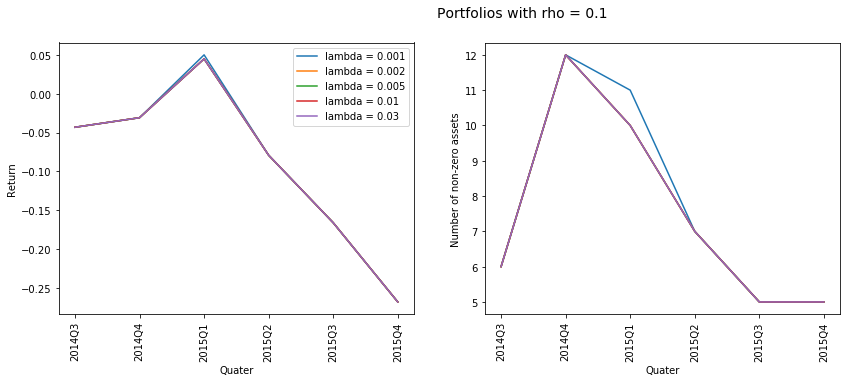

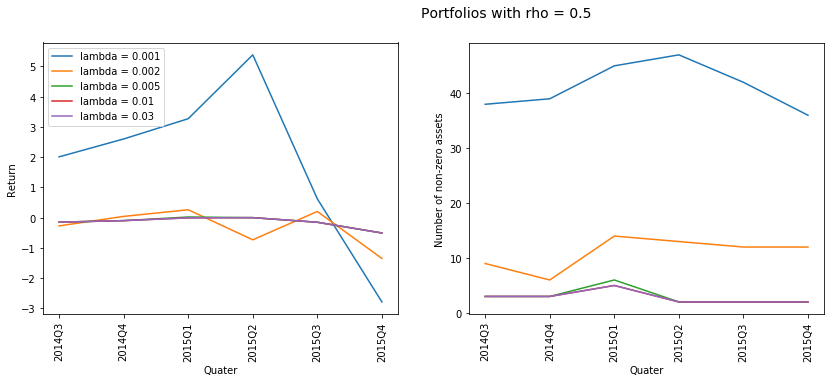

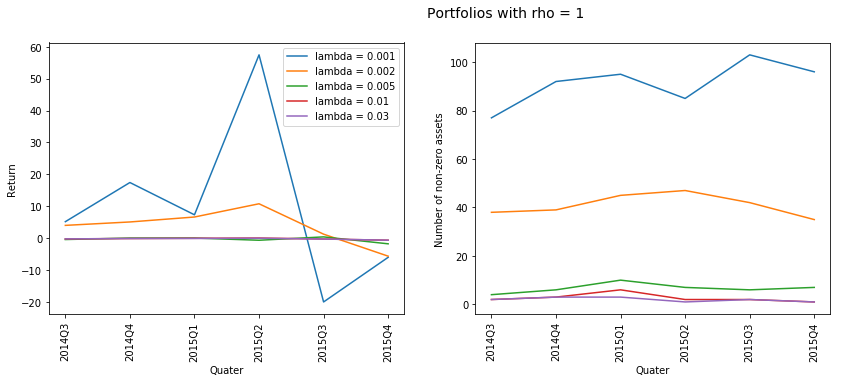

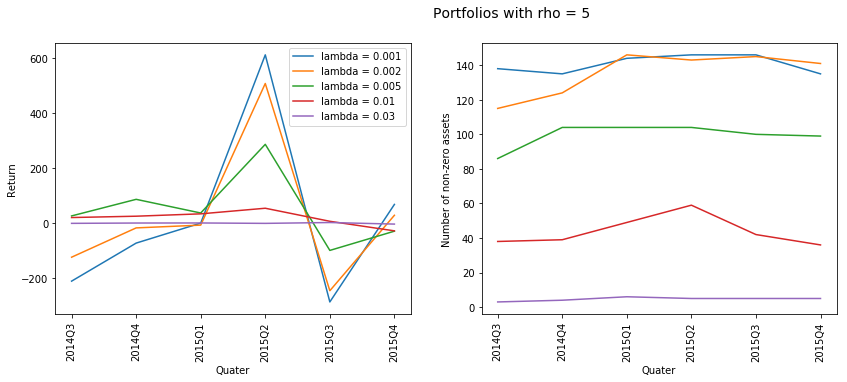

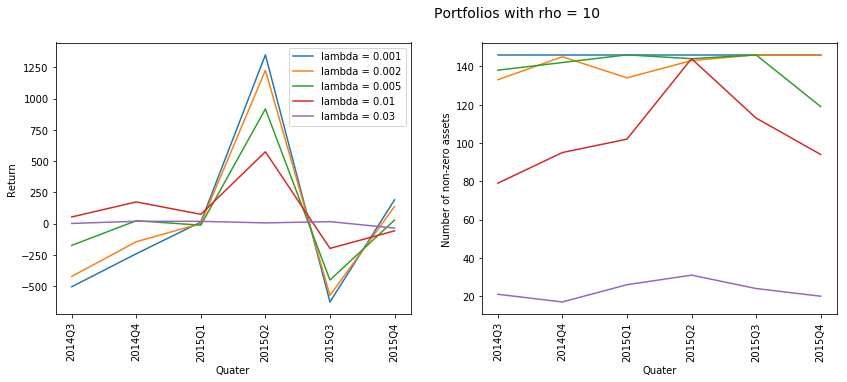

In [312]:
Q = ['2014Q3', '2014Q4', '2015Q1', '2015Q2' ,'2015Q3', '2015Q4']
for ro in [0.1, 0.5, 1, 5, 10]:
    rho = ro
    fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
    
    fig.text(0.5, 0.95,'Portfolios with rho = {}'.format(rho), size = 14)
    ax1 = axes[0]
    ax1.set_xlabel('Quater')
    ax1.set_ylabel('Return')
    ax1.set_xticks(range(6))
    ax1.set_xticklabels(Q, rotation='vertical')

    ax2 = axes[1]
    ax2.set_xlabel('Quater')
    ax2.set_ylabel('Number of non-zero assets')
    ax2.set_xticks(range(6))
    ax2.set_xticklabels(Q, rotation='vertical')
    
    for lbd in [0.001, 0.002, 0.005, 0.01, 0.03]:
        
        lambd = lbd
        total_return = []
        non_zero = []
        for i in range(q-1): 
            Sigma = np.cov(data[i,1].values.astype(float).T) + 1e-5*np.eye(n)
            r = np.mean(data[i,1], axis = 0).values
            oracle = Oracle(Sigma, r, lambd, rho)
            x = cvxpy.Variable(n)
            obj = cvxpy.Minimize(cvxpy.quad_form(x, P = Sigma) - rho*r@x + lambd*cvxpy.norm1(x))
            constr = [cvxpy.sum_entries(x) == 1]

            result = cvxpy.Problem(obj, constr).solve()
            #print(result)
            #x = ADMM(oracle, x0, 0.1, max_iter=1000, trace=True)[0]
            current_portfolio = [0 if np.abs(p) < 1.e-5 else p[0] for p in np.array(x.value)]#weights in the optimal portfolio
            #current_portfolio = [0 if np.abs(p) < 1.e-5 else p for p in np.array(x)]
            
            quater_return = np.prod(data[i+1,1].values + 1, axis=0) - 1
            total_return.append((quater_return@current_portfolio))
            non_zero.append(np.count_nonzero(current_portfolio))
    
        ax1.plot(total_return, label = 'lambda = {}'.format(lambd))
        ax2.plot(non_zero, label = 'lambda = {}'.format(lambd))
        ax1.legend()


array([[  7.16133669e-05,   8.92802466e-05,   4.78224385e-05, ...,
          1.13901962e-04,   8.26642190e-05,   6.54337666e-05],
       [  8.92802466e-05,   4.70568470e-04,   1.02534388e-04, ...,
          1.84010238e-04,   9.22403230e-05,   5.55400532e-05],
       [  4.78224385e-05,   1.02534388e-04,   1.71930764e-04, ...,
          9.56431872e-05,   6.69147019e-05,   5.15679644e-05],
       ..., 
       [  1.13901962e-04,   1.84010238e-04,   9.56431872e-05, ...,
          4.02099211e-04,   7.64611380e-05,   1.34890303e-04],
       [  8.26642190e-05,   9.22403230e-05,   6.69147019e-05, ...,
          7.64611380e-05,   5.42055948e-04,   4.95751881e-05],
       [  6.54337666e-05,   5.55400532e-05,   5.15679644e-05, ...,
          1.34890303e-04,   4.95751881e-05,   3.15548309e-04]])

In [142]:
#Different lambda
x = cvxpy.Variable(n)
obj = cvxpy.Minimize(cvxpy.quad_form(x, P = Sigma) - rho*r@x + lambd*cvxpy.norm1(x))
constr = [cvxpy.sum_entries(x) == 1]

cvxpy.Problem(obj, constr).solve()
#portfolio = x.value

0.9963793995364223

In [144]:
oracle.func(ADMM(oracle, x0, 1, max_iter=1000, trace=True)[0])

0.99638682498498987

In [270]:
x = ADMM(oracle, x0, 1, max_iter=1000, trace=True)[0]
x

array([  5.58187722e-07,   4.43572565e-01,   1.15918584e+00,
         6.23153732e-07,   7.77596252e-07,   6.88975887e-07,
         2.50696672e-07,   5.12430148e-07,   3.14102468e-07,
         4.81334080e-07,   7.72713709e-07,   1.20644207e-06,
         1.19714496e+00,   5.20979262e-07,   8.61179537e-01,
         4.29229756e-07,   6.21615698e-07,   5.96642508e-07,
         7.77381269e-07,   2.71007665e-07,   2.62454714e-07,
         1.17202355e+00,   4.50765067e-07,   4.34282085e-07,
         7.96807656e-07,   9.05710341e-07,   9.32538549e-07,
        -1.14299359e+00,  -1.08998740e+00,   4.63245143e-07,
         2.13092143e-07,   5.03080177e-07,   5.05597351e-07,
         4.97390034e-07,   5.82150094e-07,   7.62935850e-07,
         6.34350424e-07,   4.77669721e-07,   5.11769986e-07,
         4.64240883e-07,   3.17857279e-07,   3.24089215e-01,
         4.34852289e-07,   3.94304424e-07,   3.14626828e-07,
         5.41776608e-07,   5.74242270e-08,  -1.10075357e+00,
         6.74485998e-07,